In [ ]:
import time
import h5py
import matplotlib.pyplot as plt
from scipy import ndimage
from dnn_app_utils_v3 import *
from public_tests import *
import os
import json
import numpy as np
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
from sklearn.preprocessing import OneHotEncoder
import tensorflow as tf
from tensorflow.keras import layers, models

%matplotlib inline
plt.rcParams['figure.figsize'] = (5.0, 4.0) # set the default size of the plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2

np.random.seed(1) # set this to take the outputs same

In [ ]:
import os
import random
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import load_img, img_to_array
from shutil import copyfile

# the paths that defined to load the datset and create a augmented dataset
dataset_path = r"D:\ML Projects\CNN Classification\W4A2\Classifier\RealWaste"  # this is the original dataset directory
output_path = r"D:\ML Projects\CNN Classification\W4A2\Classifier\realWaste"  # this is the augmented dataset directory

# essential parameters
min_images_per_class = 318  # this is the minimum number of images to select from a class
target_images_per_class = 1000  # this is the target images after augmentation for a class

# creating the augmented dataset directory
os.makedirs(output_path, exist_ok=True)

# this is the initialization of the data augmentation gnerator
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# for process each class to the folder
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    aug_dir = os.path.join(output_path, class_name)
    os.makedirs(aug_dir, exist_ok=True)  # to create the folder for augmented images created
    
    # to get all the images in the class directory
    images = os.listdir(class_dir)
    
    # this is the Step 1: select 318 random images
    selected_images = random.sample(images, min(min_images_per_class, len(images)))
    
    # copied the selected images to the augmented folder
    for img in selected_images:
        copyfile(os.path.join(class_dir, img), os.path.join(aug_dir, img))
    
    # this is the Step 2: applied augmentation to reach the target number of images
    current_images = os.listdir(aug_dir) 
    while len(current_images) < target_images_per_class:
        for img_name in current_images:
            img_path = os.path.join(aug_dir, img_name)
            img = load_img(img_path)  # to load the image
            img_array = img_to_array(img)  # to convert to the array
            img_array = img_array.reshape((1,) + img_array.shape)  # to reshape for the generator
            
            # generate augmented images
            i = 0
            for batch in datagen.flow(img_array, batch_size=1,
                                      save_to_dir=aug_dir,
                                      save_prefix="aug",
                                      save_format="jpeg"):
                i += 1
                if len(os.listdir(aug_dir)) >= target_images_per_class:
                    break 
                if i >= 5:  # this is for limit augmentation iterations for image
                    break
        current_images = os.listdir(aug_dir)  # refreshed the list of images

print("Augmentation completed!")


Augmentation completed!


In [54]:
# set the directory path
image_dir = r'D:\ML Projects\CNN Classification\W4A2\Classifier\RealWaste'
data = []

# this is the code for loop through each type of waste folder
for waste_type in os.listdir(image_dir):
    type_path = os.path.join(image_dir, waste_type)
    if os.path.isdir(type_path):
        # this is the code for loop through each image in the waste type folder
        for image_name in os.listdir(type_path):
            if image_name.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(type_path, image_name)
                data.append({
                    'file_name': image_name,
                    'path': image_path,
                    'type': waste_type
                })

# should shuffle the dataset
np.random.seed(42)  # this is the code for reproducibility
np.random.shuffle(data)

# created lists for X and y
X = [entry['path'] for entry in data]  # this list containing image paths
y = [entry['type'] for entry in data]   # this containning corresponding labels

# encode the labels as integers and store the names
unique_classes = list(set(y))
class_mapping = {cls: idx for idx, cls in enumerate(unique_classes)}
y_encoded = [class_mapping[label] for label in y]
y_names = [unique_classes[label] for label in y_encoded]  # Store original names corresponding to encoded labels

# training (60%), validation (20%), and testing (20%)
train_x, temp_x, train_y, temp_y, train_y_names, temp_y_names = train_test_split(X, y_encoded, y_names, test_size=0.4, random_state=42)
val_x, test_x, val_y, test_y, val_y_names, test_y_names = train_test_split(temp_x, temp_y, temp_y_names, test_size=0.5, random_state=42)

# dataset dictionary
dataset = {
    'train': {'X': train_x, 'y': train_y, 'y_names': train_y_names},
    'validation': {'X': val_x, 'y': val_y, 'y_names': val_y_names},
    'test': {'X': test_x, 'y': test_y, 'y_names': test_y_names},
    'class_mapping': class_mapping  # this is the class mapping for reference
}

# save the dataset to a JSON file that is pretty easy to use further times @Nimantha, @Mahen, @Govindu take this JSON file and improve further more
json_file_path = 'waste_images_dataset_split.json'
with open(json_file_path, 'w') as json_file:
    json.dump(dataset, json_file, indent=4)

print(f"Dataset split into train, validation, and test sets and saved to {json_file_path}.")


Dataset split into train, validation, and test sets and saved to waste_images_dataset_split.json.


Image shape: (160, 160, 3)
y = 2. It's a Plastic picture.


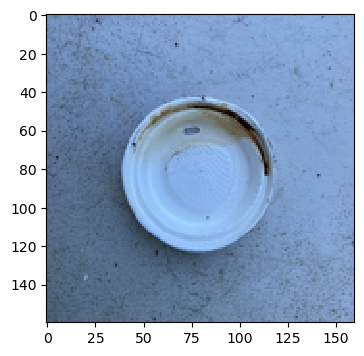

In [61]:
# by loading the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

train_data = dataset['train']
train_x = train_data['X'] 
train_y = train_data['y']   

# this is an example choose an index for display an image to see whether the code is working correctly
index = 6
num_px = 160

image_path = train_x[index]
image = Image.open(image_path).resize((num_px, num_px))  # resizing 
plt.imshow(image)

# print the shape of the image to get a clear understanding on the pixels
print("Image shape:", np.array(image).shape)

label = train_y_names[index]
label_number = train_y[index]
print("y = " + str(label_number) + ". It's a " + label + " picture.")
# this indexes and places where the classes exist can be changed when you come top to the bottom through the code so check this out and proceed @Nimantha, @Govindu, @Mahen 
classes = ["Food Organics", "Cardboard", "Plastic", "Textile Trash", "Glass", "Metal", "Paper", "Vegetation"]


In [ ]:
from sklearn.preprocessing import OneHotEncoder
import numpy as np
from PIL import Image
import json

# loading the dataset from the JSON file
json_file_path = 'waste_images_dataset_split.json'

with open(json_file_path, 'r') as json_file:
    dataset = json.load(json_file)

# this is the code for extract the training and testing data
train_data = dataset['train']
test_data = dataset['test']

# this is the number of pixels for resizing images
num_px = 224  

# this is the codelines for process the dataset
train_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255.0 for image_path in train_data['X']])
train_y = np.array(train_data['y'])
train_y_names = np.array(train_data['y_names'])  # adding the names for training set

test_x = np.array([np.array(Image.open(image_path).resize((num_px, num_px))) / 255.0 for image_path in test_data['X']])
test_y = np.array(test_data['y'])
test_y_names = np.array(test_data['y_names'])  # adding the names for testing set

# one-hot encode the labels have been chosen for the final out come
encoder = OneHotEncoder(sparse_output=False, categories='auto')  
train_y_one_hot = encoder.fit_transform(train_y.reshape(-1, 1))  # reshape for encoder
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # transformed test set

# exploration of the dataset
m_train = train_x.shape[0]
num_px = train_x.shape[1]  # set as square images
m_test = test_x.shape[0]

print("Number of training examples: " + str(m_train))
print("Number of testing examples: " + str(m_test))
print("Each image is of size: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print("train_x shape: " + str(train_x.shape))
print("train_y shape (original): " + str(train_y.shape))
print("train_y shape (one-hot): " + str(train_y_one_hot.shape))
print("test_x shape: " + str(test_x.shape))
print("test_y shape (original): " + str(test_y.shape))
print("test_y shape (one-hot): " + str(test_y_one_hot.shape))

Number of training examples: 5400
Number of testing examples: 1800
Each image is of size: (224, 224, 3)
train_x shape: (5400, 224, 224, 3)
train_y shape (original): (5400,)
train_y shape (one-hot): (5400, 9)
test_x shape: (1800, 224, 224, 3)
test_y shape (original): (1800,)
test_y shape (one-hot): (1800, 9)


In [ ]:
# to get the corresponding label
classes = ["Food Organics", "Cardboard", 
           "Plastic", "Miscellaneous Trash", 
           "Textile Trash", "Glass", "Metal", 
           "Paper", "Vegetation"]
index = 3902
label = train_y_names[index]
label_number = train_y[index]
print("y = " + str(label_number) + ". It's a " + label + " picture.")
print(train_y_one_hot[index])

y = 2. It's a Plastic picture.
[0. 0. 1. 0. 0. 0. 0. 0. 0.]


In [ ]:
from tensorflow.keras.applications import MobileNet
from tensorflow.keras import layers, models

# by loading the MobileNet model with pre-trained ImageNet weights
MobileNet_base_model = MobileNet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 9

# added some custom classification layers to match our final out come
x = layers.GlobalAveragePooling2D()(MobileNet_base_model.output)  # a global average pooling instead of flattening
x = layers.Dense(128, activation='relu')(x)            # a fully connected layer
output = layers.Dense(num_classes, activation='softmax')(x)  # this is the output layer with count of the classes

# new model
MobileNet_model = models.Model(inputs=MobileNet_base_model.input, outputs=output)

# summary
MobileNet_model.summary()


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,361,225 (12.82 MB)

 Trainable params: 3,339,337 (12.74 MB)

 Non-trainable params: 21,888 (85.50 KB)

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models

# by loading the ResNet50 model with pre trained ImageNet weights
ResNet_base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
num_classes = 9

# added custom classification layers to match our final outcomes (count of classes)
x = layers.GlobalAveragePooling2D()(ResNet_base_model.output)  # a global average pooling
x = layers.Dense(128, activation='relu')(x)            # a fully connected layer
output = layers.Dense(num_classes, activation='softmax')(x)  # an output layer

# new model
ResNet_model = models.Model(inputs=ResNet_base_model.input, outputs=output)

# summary
ResNet_model.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_5[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,851,145 (90.98 MB)

 Trainable params: 23,798,025 (90.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [ ]:
# example prints to check whether the code is working correctly
print("Shape of train_x:", train_x.shape)
print("Shape of train_y:", train_y_one_hot.shape)

# assigned the shape values for further use
num_train_x = train_x.shape[0]
print(num_train_x)
num_test_x = test_x.shape[0]
print(num_test_x)

Shape of train_x: (5400, 224, 224, 3)
Shape of train_y: (5400, 9)
5400
1800


In [ ]:
# this can keep train_y and train_y_names as is:
train_y = train_y.reshape(num_train_x,)  
train_y_names = train_y_names.reshape(num_train_x,)  # I kept it 1D for single label representation

# do not need to reshape test_y and test_y_names unless have a specific reason to do so
test_y_names = test_y_names.reshape(num_test_x,)  
test_y = test_y.reshape(num_test_x,)  # I kept it 1D for single label representation

# one hot encoding for test_y:
test_y_one_hot = encoder.transform(test_y.reshape(-1, 1))  # converted to one hot for test set

# to check the shapes
print("train_y shape:", train_y.shape)
print("train_y_names shape:", train_y_names.shape)
print("train_y_one_hot shape:", train_y_one_hot.shape)
print("test_y shape:", test_y.shape)
print("test_y_names shape:", test_y_names.shape)
print("test_y_one_hot shape:", test_y_one_hot.shape)


train_y shape: (5400,)
train_y_names shape: (5400,)
train_y_one_hot shape: (5400, 9)
test_y shape: (1800,)
test_y_names shape: (1800,)
test_y_one_hot shape: (1800, 9)


In [ ]:
# this is optional: Freeze the base model layers to get trainable or not
for layer in MobileNet_model.layers:
    layer.trainable = True

learning_rate = 0.001 # set the learning rate as 0.001 or 0.001 at the begining

# Compile the model
# MobileNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

MobileNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
metrics=['accuracy'])

In [53]:
# train the model
history_MobileNet = MobileNet_model.fit(train_x, train_y_one_hot, epochs=15, batch_size=32, validation_data=(test_x, test_y_one_hot))

Epoch 1/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 438s 3s/step - accuracy: 0.6273 - loss: 1.0995 - val_accuracy: 0.5950 - val_loss: 1.7250
Epoch 2/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.8580 - loss: 0.4093 - val_accuracy: 0.7606 - val_loss: 0.7588
Epoch 3/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 428s 3s/step - accuracy: 0.9099 - loss: 0.2632 - val_accuracy: 0.6050 - val_loss: 1.3928
Epoch 4/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9229 - loss: 0.2160 - val_accuracy: 0.7450 - val_loss: 0.9610
Epoch 5/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 395s 2s/step - accuracy: 0.9382 - loss: 0.1728 - val_accuracy: 0.6522 - val_loss: 1.3365
Epoch 6/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 393s 2s/step - accuracy: 0.9421 - loss: 0.1617 - val_accuracy: 0.7683 - val_loss: 0.8772
Epoch 7/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.9558 - loss: 0.1386 - val_accuracy: 0.7694 - val_loss: 0.8535
Epoch 8/15
169/169 ━━━━━━━━━━━━━━━━━━━━ 411s 2s/step - accuracy: 0.9593 - loss: 0.1158 - val_accu

In [ ]:
# this is optional: Freeze the base model layers to enable the trainable parameters or not
for layer in ResNet_base_model.layers:
    layer.trainable = False

learning_rate = 0.001

# Compile the model
# ResNet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
ResNet_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
loss='binary_crossentropy' if num_classes == 1 else 'categorical_crossentropy',
metrics=['accuracy'])

In [ ]:
# train the model
history_ResNet = ResNet_model.fit(train_x, train_y_one_hot, epochs=15, batch_size=32, validation_data=(test_x, test_y_one_hot))

Epoch 1/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 778s 2s/step - accuracy: 0.1635 - loss: 2.1799 - val_accuracy: 0.2283 - val_loss: 2.1005
Epoch 2/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 721s 2s/step - accuracy: 0.2405 - loss: 2.0207 - val_accuracy: 0.2693 - val_loss: 1.9901
Epoch 3/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 725s 2s/step - accuracy: 0.2711 - loss: 1.9530 - val_accuracy: 0.2760 - val_loss: 1.9174
Epoch 4/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 727s 2s/step - accuracy: 0.2897 - loss: 1.9094 - val_accuracy: 0.2956 - val_loss: 1.8976
Epoch 5/15
 16/393 ━━━━━━━━━━━━━━━━━━━━ 9:04 1s/step - accuracy: 0.2934 - loss: 1.8952

KeyboardInterrupt: 

['Glass', 'Plastic', 'Metal', 'Miscellaneous Trash', 'Cardboard', 'Food Organics', 'Textile Trash', 'Paper', 'Vegetation']
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


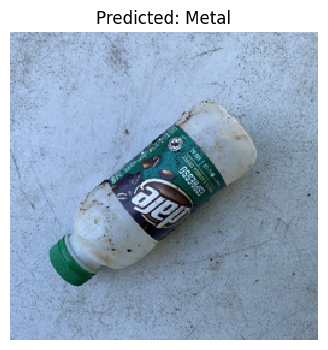

Predicted class index: 2
Predicted class name: "Metal"


In [ ]:
def predict_class(image_path, model, class_names, num_px=224):
    """
    Function to predict the class of an image and return the class name, while displaying the image.
    
    Parameters:
    - image_path: str, path to the image to be predicted.
    - model: trained Keras model.
    - class_names: list of str, names of classes corresponding to model output indices.
    - num_px: int, pixel dimension to resize the image to (assuming square images).

    Returns:
    - predicted_class_name: str, name of the predicted class.
    """
    # load and preprocess the image
    image = Image.open(image_path).resize((num_px, num_px))
    image_array = np.array(image) / 255.0  # Normalize pixel values
    image_input = image_array.reshape((1, num_px, num_px, 3))  # Add batch dimension

    # predict using the model
    predictions = model.predict(image_input)
    
    # get the index of the highest probability
    predicted_class_index = np.argmax(predictions[0])
    
    # retrieve the class name from class_names using the predicted index
    predicted_class_name = class_names[predicted_class_index]

    # display the image with the predicted class name
    plt.imshow(image_array)
    plt.title(f"Predicted: {predicted_class_name}")
    plt.axis('off')
    plt.show()

    # print the prediction result
    print(f"Predicted class index: {predicted_class_index}")
    print(f"Predicted class name: \"{predicted_class_name}\"")
    
    return predicted_class_name

# this is the example usage:
# assuming `train_y_names` holds the names of the classes corresponding to indices 0–8.
print(classes)
image_path = "D:\ML Projects\CNN Classification\W4A2\Classifier\images\Plastic.jpg"  # Replace with your image path
predicted_class_name = predict_class(image_path, model, classes)
